In [ ]:
%pip install qiskit --quiet
%pip install pylatexenc --quiet
%pip install qiskit-aer --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 97.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
import pandas as pd
import numpy as np
from tensorflow import keras
df = pd.read_csv(r'/content/drive/MyDrive/LLM Healthcare/mtsamples.csv', header=None)

In [27]:
text_col = df.iloc[:, 4]
yes_texts = []
no_texts = []

for text in text_col.dropna():
    if 'diabetes' in text.lower():
        if len(yes_texts) < 100:
            yes_texts.append(text)
    else:
        if len(no_texts) < 100:
            no_texts.append(text)
    if len(yes_texts) >= 100 and len(no_texts) >= 100:
        break

texts = yes_texts + no_texts
labels = [1] * 100 + [0] * 100
word_counts = {}
for sentence in texts:
    for word in sentence.split():
        word_counts[word] = word_counts.get(word, 0) + 1

word_counts = sorted(word_counts.items(), key=lambda x: -x[1])
word_index = {word: i+1 for i, (word, _) in enumerate(word_counts)}
word_index['PAD'] = 0
word_index = dict(sorted(word_index.items(), key=lambda x: x[1]))

def tokenize(sentences):
    tokenized = []
    for sentence in sentences:
        tokenized.append([word_index.get(word, 0) for word in sentence.split()])
    return tokenized

tokenized_data = tokenize(texts)

max_length = 51
padded_data = keras.preprocessing.sequence.pad_sequences(tokenized_data, maxlen=max_length, padding='post')

final_data = pd.DataFrame(np.c_[padded_data, labels])
m_data = padded_data
m_label = labels

In [28]:
final_data

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,4454,2645,4455,936,2646,2647,249,4456,699,3287,...,806,3291,39,514,6833,4465,6834,39,1651,1
1,1313,56,4487,19,43,338,5,663,5,56,...,10,1655,72,43,6906,186,12,2657,6907,1
2,43,1109,1,240,2670,1476,2222,267,2670,1318,...,1,11,5,1109,6,4518,561,194,3323,1
3,11,10,215,3330,12,666,18,30,1666,68,...,38,22,882,5,284,186,9,6,1111,1
4,4605,1484,2676,19,13,51,135,9,30,4606,...,2688,1906,1316,12,2689,62,43,34,2688,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,9,1572,2404,6760,7,1262,4,1,81,202,...,1,243,628,7,11,178,1,96,199,0
196,3,60,8,170,455,461,2636,88,315,1293,...,208,12,6,1035,4,1,239,9,14185,0
197,2,1855,901,15,60,8,182,276,88,2,...,20,65,5,1,243,102,9,111,238,0
198,455,1967,841,79,1414,3,40,14,92,4326,...,9,135,760,394,1623,5,1,243,628,0


In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import KMeans
import qiskit
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, ZZFeatureMap, TwoLocal

In [30]:
def U_circuit(qc,theta):
  qc.u(theta[0],0,0,0)
  qc.cu(theta[1],0,0,0,0,1)
  qc.x(0)
  qc.cu(theta[2],0,0,0,0,1)
  qc.x(0)

  qc.mcx([0, 1], 3)
  qc.cu(theta[3],0,0,0,3,2)
  qc.mcx([0, 1], 3)

  qc.x(0)
  qc.mcx([0, 1], 3)
  qc.cu(theta[4],0,0,0,3,2)
  qc.mcx([0, 1], 3)
  qc.x(0)

  qc.x(1)
  qc.mcx([0, 1], 3)
  qc.cu(theta[5],0,0,0,3,2)
  qc.mcx([0, 1], 3)
  qc.x(1)

  qc.x(0)
  qc.x(1)
  qc.mcx([0, 1], 3)
  qc.cu(theta[6],0,0,0,3,2)
  qc.mcx([0, 1], 3)
  qc.x(0)
  qc.x(1)
  return qc

In [31]:
def U_circuit_rev(qc,theta):
  qc.x(0)
  qc.x(1)
  qc.mcx([0, 1], 3)
  qc.cu(-theta[6],0,0,0,3,2)
  qc.mcx([0, 1], 3)
  qc.x(0)
  qc.x(1)

  qc.x(1)
  qc.mcx([0, 1], 3)
  qc.cu(-theta[5],0,0,0,3,2)
  qc.mcx([0, 1], 3)
  qc.x(1)

  qc.x(0)
  qc.mcx([0, 1], 3)
  qc.cu(-theta[4],0,0,0,3,2)
  qc.mcx([0, 1], 3)
  qc.x(0)

  qc.mcx([0, 1], 3)
  qc.cu(-theta[3],0,0,0,3,2)
  qc.mcx([0, 1], 3)

  qc.x(0)
  qc.cu(-theta[2],0,0,0,0,1)
  qc.x(0)

  qc.cu(-theta[1],0,0,0,0,1)

  qc.u(-theta[0],0,0,0)

  return qc

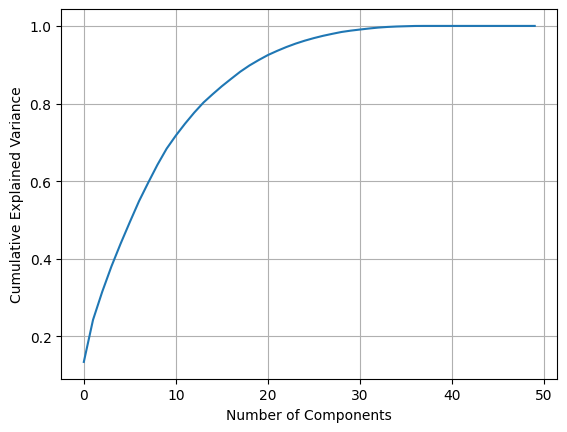

In [32]:
N =4
num_data_points = 50
test_size = 0.2

zeros_string = '0' * N
Num_shots = 1024

num_components = 0
for i in range(N):
    num_components += 2 ** i

df_sampled = final_data.sample(n=num_data_points, replace=True, random_state=42)

X = df_sampled.iloc[:, :-1]
y = df_sampled.iloc[:, -1]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

n_components = min(X_scaled.shape[0], X_scaled.shape[1])
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

pca = PCA().fit(X_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


In [33]:
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(df_pca)

centroids = kmeans.cluster_centers_

# Print centroid 0 and centroid 1
centroid_0 = centroids[0]
centroid_1 = centroids[1]

# Add the cluster labels to the DataFrame
df_pca['Cluster'] = labels

A = df_pca.drop('Cluster', axis=1)
B = df_pca['Cluster']

In [34]:
def run_qsvm(X, y, centroids, N, Num_shots=124):
    zeros_string = '0' * N
    predicted_labels = []

    for i in range(len(X)):
        x = X.iloc[i].values

        qc1 = QuantumCircuit(N+1, N)

        ansatz = ZZFeatureMap(N+1, reps=2, entanglement='linear')
        param_values = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=ansatz.num_parameters)
        #print(param_values)
        ansatz.assign_parameters(param_values, inplace=True)
        qc1.compose(ansatz.decompose(), inplace=True)

        ansatz = TwoLocal(N+1, reps=2, entanglement='linear')
        param_values = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=ansatz.num_parameters)
        #print(param_values)
        ansatz.assign_parameters(param_values, inplace=True)
        qc1.compose(ansatz.decompose(), inplace=True)

        qc1 = U_circuit(qc1, x)
        qc1 = U_circuit_rev(qc1, centroids[0])
        qc1.measure(range(N), range(N))
        backend = AerSimulator(method='automatic')

        # Transpile the circuit
        #pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)
        #transpiled_qc1 = pass_manager.run(qc1)
        result1 = backend.run(qc1, shots=Num_shots).result()
        p0_qc1 = result1.get_counts(0).get(zeros_string, 0) / Num_shots

        qc2 = QuantumCircuit(N+1, N)
        qc2 = U_circuit(qc2, x)
        qc2 = U_circuit_rev(qc2, centroids[1])
        qc2.measure(range(N), range(N))
        # Transpile the circuit
        #pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)
        #transpiled_qc2 = pass_manager.run(qc2)
        result2 = backend.run(qc2, shots=Num_shots).result()
        p0_qc2 = result2.get_counts(0).get(zeros_string, 0) / Num_shots

        predicted_labels.append(0 if p0_qc1 > p0_qc2 else 1)

    return predicted_labels


In [35]:
# 5-Fold CV
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True)

accuracies = []
precisions = []
recalls = []
f1s = []

for train_index, test_index in skf.split(A, B):
    X_train, X_test = A.iloc[train_index], A.iloc[test_index]
    y_train, y_test = B.iloc[train_index], B.iloc[test_index]

    # Recalculate centroids for this fold
    kmeans = KMeans(n_clusters=num_clusters,)
    kmeans.fit(X_train)
    fold_centroids = kmeans.cluster_centers_

    y_pred = run_qsvm(X_test, y_test, fold_centroids, N)

    # Collect metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
    recalls.append(recall_score(y_test, y_pred, average='weighted'))
    f1s.append(f1_score(y_test, y_pred, average='weighted'))

# Print results
print("-----------------------------------------------------------------")
print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1-score: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")
print("-----------------------------------------------------------------")

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/tmp/ipython-input-1772172141.py:10: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  ansatz = ZZFeatureMap(N+1, reps=2, entanglement='linear')
/tmp/ipython-input-1772172141.py:16: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  ansatz = TwoLocal(N+1, reps=2, entanglement='linear')
/tmp/ipython-input-1772172141.py:10: DeprecationWarning: The class ``qiskit.circuit.library.data_prepar

-----------------------------------------------------------------
Accuracy: 0.9800 ± 0.0400
Precision: 0.9620 ± 0.0760
Recall: 0.9800 ± 0.0400
F1-score: 0.9705 ± 0.0589
-----------------------------------------------------------------


/tmp/ipython-input-1772172141.py:10: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  ansatz = ZZFeatureMap(N+1, reps=2, entanglement='linear')
/tmp/ipython-input-1772172141.py:16: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  ansatz = TwoLocal(N+1, reps=2, entanglement='linear')


In [36]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_iris

# Assuming m_data and m_label are already defined
X, y = m_data, m_label

# Cross-validation setup
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define models in a dictionary
models = {
    'SVC': make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1.0, gamma='scale')),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5)),
    'Logistic Regression': make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))
}

# Metrics to evaluate
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

# Evaluate each model
for name, model in models.items():
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring)
    print("-----------------------------------------------------------------")
    print(f"{name}:")
    print(f"  Accuracy : {scores['test_accuracy'].mean():.4f} ± {scores['test_accuracy'].std():.4f}")
    print(f"  Precision: {scores['test_precision_weighted'].mean():.4f} ± {scores['test_precision_weighted'].std():.4f}")
    print(f"  Recall   : {scores['test_recall_weighted'].mean():.4f} ± {scores['test_recall_weighted'].std():.4f}")
    print(f"  F1-score : {scores['test_f1_weighted'].mean():.4f} ± {scores['test_f1_weighted'].std():.4f}")
    print("-----------------------------------------------------------------")

-----------------------------------------------------------------
SVC:
  Accuracy : 0.6900 ± 0.0889
  Precision: 0.7057 ± 0.0914
  Recall   : 0.6900 ± 0.0889
  F1-score : 0.6825 ± 0.0934
-----------------------------------------------------------------
-----------------------------------------------------------------
Random Forest:
  Accuracy : 0.7700 ± 0.0557
  Precision: 0.7919 ± 0.0581
  Recall   : 0.7700 ± 0.0557
  F1-score : 0.7653 ± 0.0596
-----------------------------------------------------------------
-----------------------------------------------------------------
KNN:
  Accuracy : 0.4750 ± 0.1101
  Precision: 0.4734 ± 0.1170
  Recall   : 0.4750 ± 0.1101
  F1-score : 0.4640 ± 0.1111
-----------------------------------------------------------------
-----------------------------------------------------------------
Logistic Regression:
  Accuracy : 0.5950 ± 0.0522
  Precision: 0.6032 ± 0.0567
  Recall   : 0.5950 ± 0.0522
  F1-score : 0.5882 ± 0.0539
----------------------------